# Implementing GAN for Generation of MNIST digits

Generative Adversarial Networks (GANs) can be broken down into three parts:

* Generative: To learn a generative model, which describes how data is generated in terms of a probabilistic model.
* Adversarial: The training of a model is done in an adversarial setting.
* Networks: Use deep neural networks as the artificial intelligence (AI) algorithms for training purpose.

> In GANs, there is a generator and a discriminator. The Generator generates fake samples of data(be it an image, audio, etc.) and tries to fool the Discriminator. The Discriminator, on the other hand, tries to distinguish between the real and fake samples. The Generator and the Discriminator are both Neural Networks and they both run in competition with each other in the training phase. The steps are repeated several times and in this, the Generator and Discriminator get better and better in their respective jobs after each repetition. The working can be visualized by the diagram given below:

<center><img src = 'https://media.geeksforgeeks.org/wp-content/uploads/gans_gfg.jpg' width = 700></center>

> Here, the generative model captures the distribution of data and is trained in such a manner that it tries to maximize the probability of the Discriminator in making a mistake. The Discriminator, on the other hand, is based on a model that estimates the probability that the sample that it got is received from the training data and not from the Generator.
The GANs are formulated as a minimax game, where the Discriminator is trying to minimize its reward V(D, G) and the Generator is trying to minimize the Discriminator’s reward or in other words, maximize its loss. It can be mathematically described by the formula below:


<center><img src = 'https://media.geeksforgeeks.org/wp-content/uploads/g22-1.png' width = 700></center>



So, basically, training a GAN has two parts:

> Part 1: The Discriminator is trained while the Generator is idle. In this phase, the network is only forward propagated and no back-propagation is done. The Discriminator is trained on real data for n epochs, and see if it can correctly predict them as real. Also, in this phase, the Discriminator is also trained on the fake generated data from the Generator and see if it can correctly predict them as fake.

> Part 2: The Generator is trained while the Discriminator is idle. After the Discriminator is trained by the generated fake data of the Generator, we can get its predictions and use the results for training the Generator and get better from the previous state to try and fool the Discriminator.
The above method is repeated for a few epochs and then manually check the fake data if it seems genuine. If it seems acceptable, then the training is stopped, otherwise, its allowed to continue for few more epochs.

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.datasets import mnist
from tqdm import tqdm
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam 

# Loading MNIST data

In [2]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5   
    x_test = (x_test.astype(np.float32) - 127.5)/127.5  
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    x_test = x_test.reshape(10000, 784)
    return (x_train, y_train, x_test, y_test)
(X_train, y_train,X_test, y_test)=load_data()
print(X_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(10000, 784)


In [3]:
def adam_optimizer():
    return Adam(learning_rate=0.001)

# Creating a Generator

In [4]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    generator.add(BatchNormalization())
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2)) 
    generator.add(BatchNormalization())
    generator.add(Dropout(0.5))
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))  
    generator.add(BatchNormalization())
    generator.add(Dropout(0.5))
    generator.add(Dense(units=784, activation='tanh'))   
    generator.compile(optimizer=adam_optimizer(),loss='binary_crossentropy')
    return generator
g=create_generator()
g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                        

# Discriminator Function

In [5]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(BatchNormalization())
    discriminator.add(Dropout(0.3))      
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(BatchNormalization())
    discriminator.add(Dropout(0.3))     
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(BatchNormalization())   
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(units=1, activation='sigmoid'))  
    discriminator.compile(loss='binary_crossentropy', optimizer="sgd")
    return discriminator
d =create_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1024)              0         
                                                                 
 batch_normalization_3 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                      

# Creating the GAN

In [6]:
def create_gan(discriminator, generator):
    # At first we are making discriminator weights as constant by not training them
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer="Adam")
    return gan
gan = create_gan(d,g)
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               1493520   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1467393   
                                                                 
Total params: 2,960,913
Trainable params: 1,489,936
Non-trainable params: 1,470,977
_________________________________________________________________


# Plotting the Generated Images for visulaization

In [7]:
!mkdir /content/Images
!mkdir /content/models
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('/content/Images/gan_generated_image %d.png' %epoch)
    plt.show()

# Training GAN

In [ ]:

def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = int(X_train.shape[0] / batch_size)
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in range(batch_count):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=1
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if (e == 1) or (e % 10 == 0):
          path = '/content/models/epoch'+str(e)
          generator.save(path)
          plot_generated_images(e, generator)

training(50,128)

In [10]:
generator_model = tf.keras.models.load_model('/content/models/epoch50')

****************************************************************************************************

 Generating image set 1 from junk numbers

****************************************************************************************************
4/4 [==============================] - 0s 7ms/step


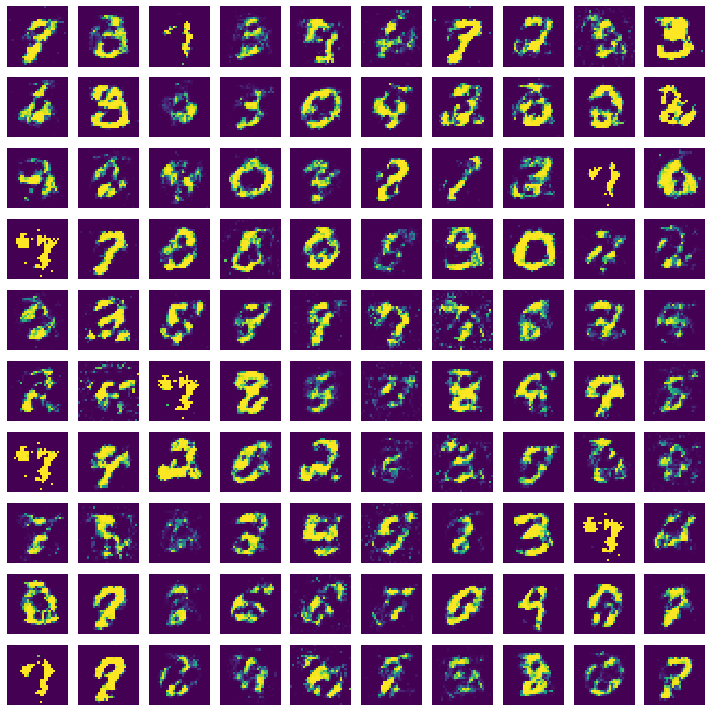

****************************************************************************************************

 Generating image set 2 from junk numbers

****************************************************************************************************
4/4 [==============================] - 0s 8ms/step


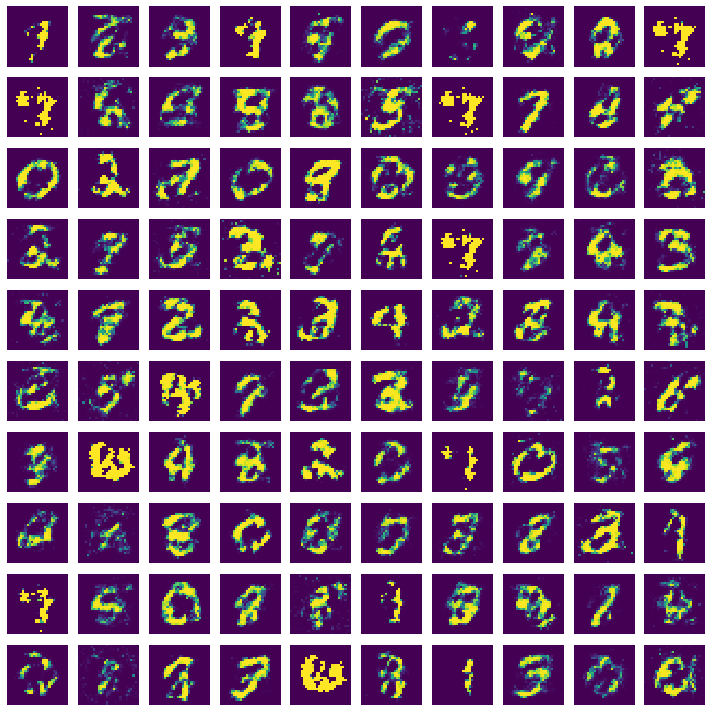

****************************************************************************************************

 Generating image set 3 from junk numbers

****************************************************************************************************
4/4 [==============================] - 0s 11ms/step


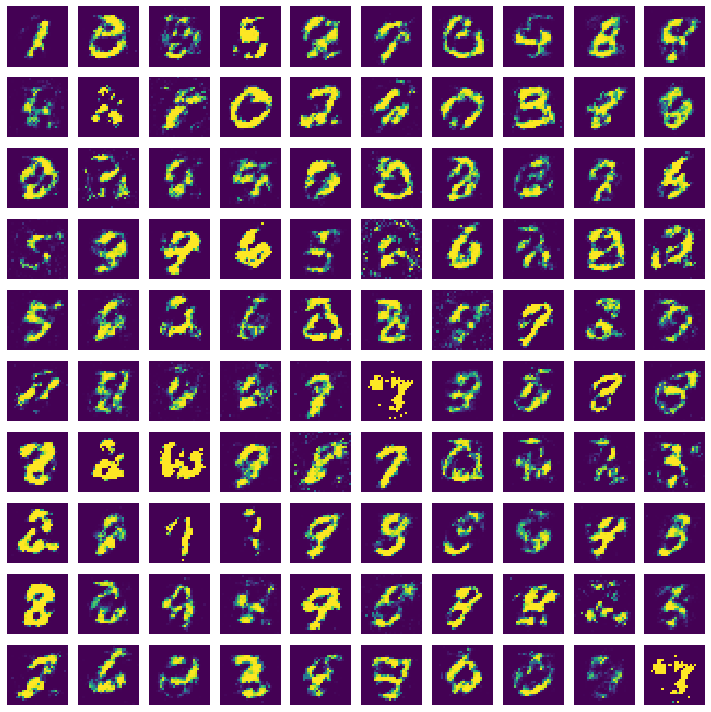

****************************************************************************************************

 Generating image set 4 from junk numbers

****************************************************************************************************
4/4 [==============================] - 0s 10ms/step


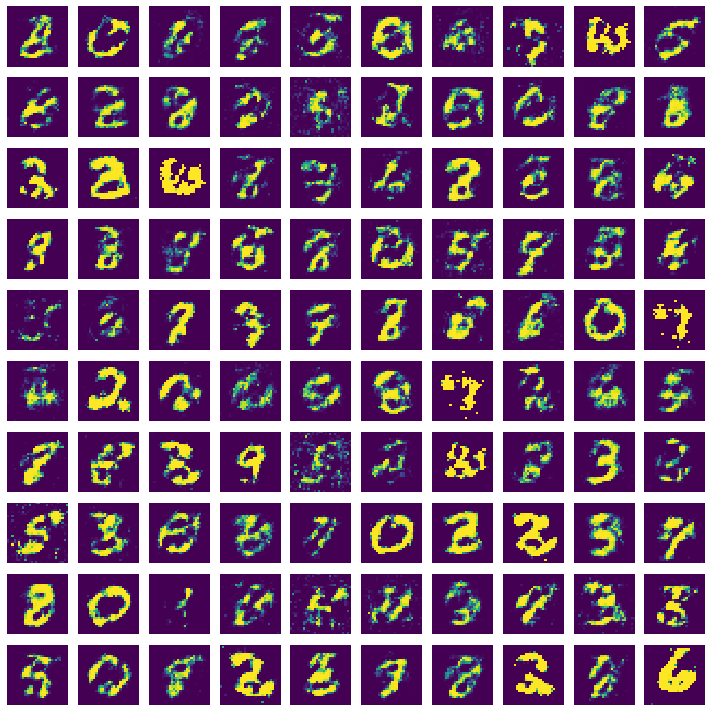

****************************************************************************************************

 Generating image set 5 from junk numbers

****************************************************************************************************
4/4 [==============================] - 0s 8ms/step


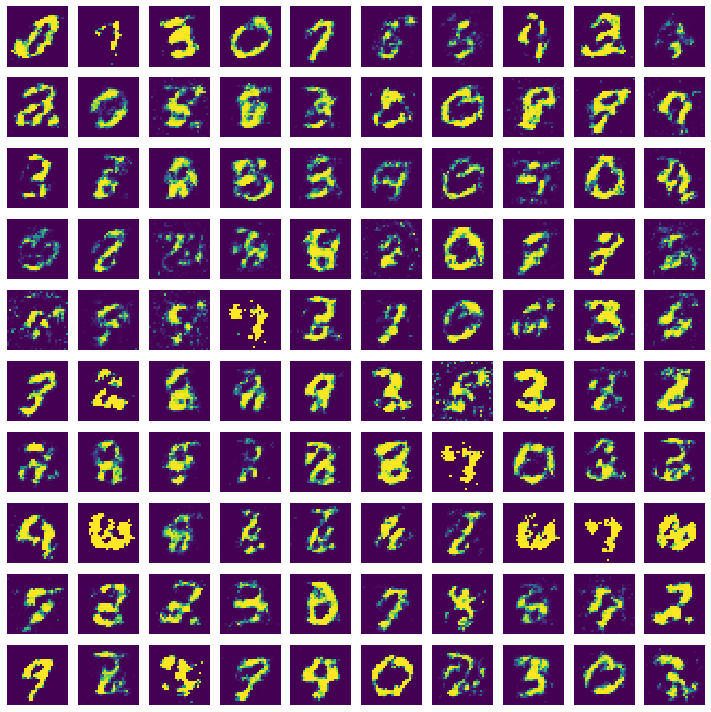

****************************************************************************************************

 Generating image set 6 from junk numbers

****************************************************************************************************
4/4 [==============================] - 0s 13ms/step


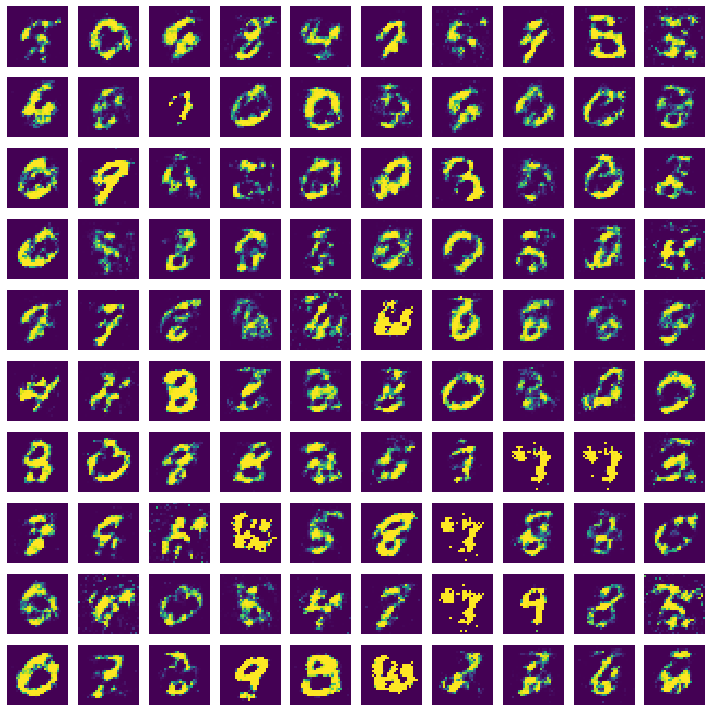

****************************************************************************************************

 Generating image set 7 from junk numbers

****************************************************************************************************
4/4 [==============================] - 0s 9ms/step


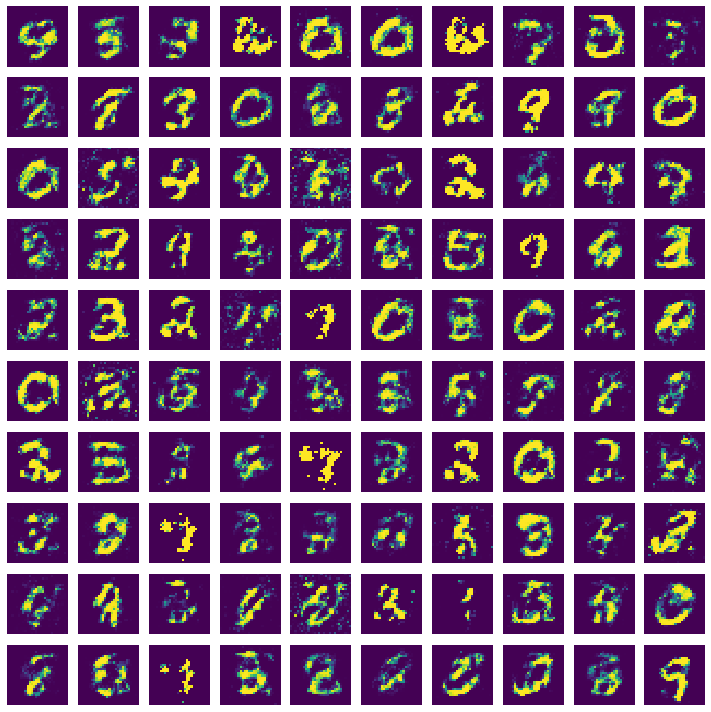

****************************************************************************************************

 Generating image set 8 from junk numbers

****************************************************************************************************
4/4 [==============================] - 0s 10ms/step


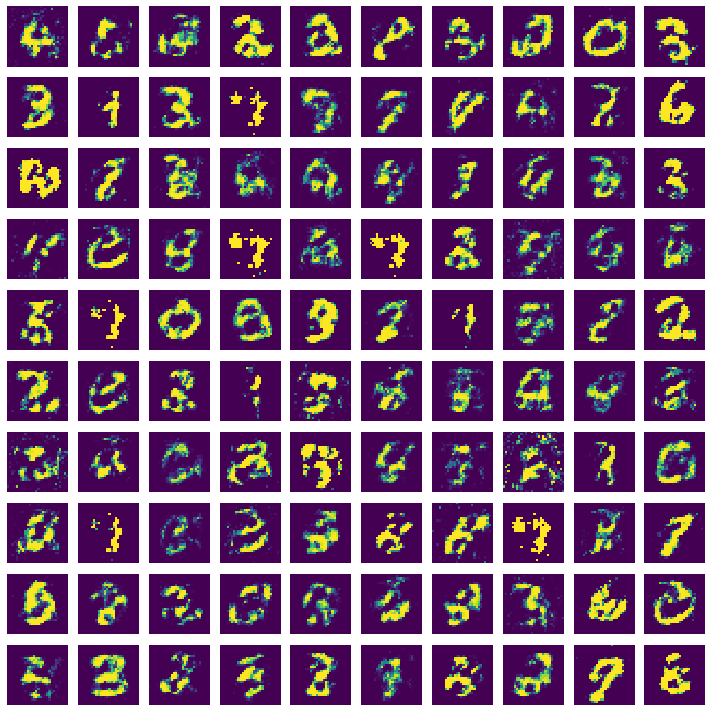

****************************************************************************************************

 Generating image set 9 from junk numbers

****************************************************************************************************
4/4 [==============================] - 0s 12ms/step


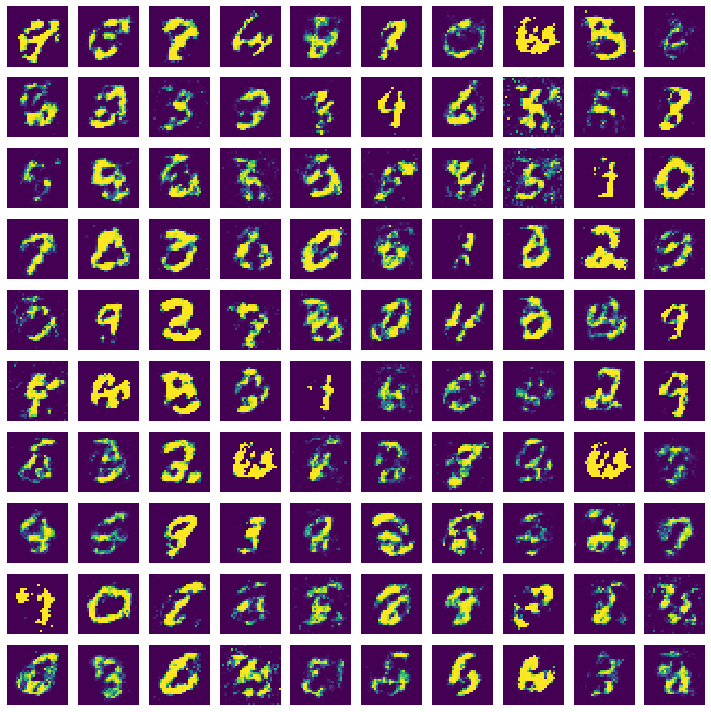

****************************************************************************************************

 Generating image set 10 from junk numbers

****************************************************************************************************
4/4 [==============================] - 0s 9ms/step


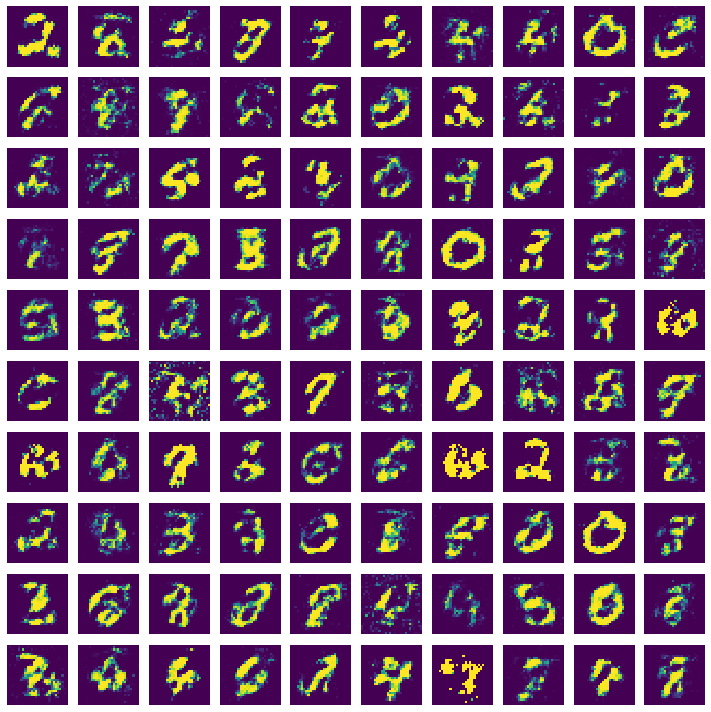

In [12]:
for i in range(10):
  dummy = 1
  print('*'*100)
  print()
  print(' Generating image set {} from junk numbers'.format(i+1))
  print()
  print('*'*100)
  plot_generated_images(dummy, generator_model)